VENUS NOTEBOOK TAKE 2

In [1]:
using Revise
using PyPlot
using PyCall
using HDF5
using DataFrames
using Interpolations 
using DelimitedFiles
using XLSX
using Printf
photochemistry_source_dir = "$(@__DIR__)/Photochemistry/src/"
println("loading Photochemistry.jl from $photochemistry_source_dir")
push!(LOAD_PATH, photochemistry_source_dir)
using Photochemistry  # custom module
using QuadGK
import Base.@kwdef
using GeneralizedGenerated

loading Photochemistry.jl from /home/emc/OneDrive-CU/Research/Venus/Code/Photochemistry/src/


┌ Info: Precompiling Photochemistry [top-level]
└ @ Base loading.jl:1423


In [2]:
include("CUSTOMIZATIONS.jl");
include("CONSTANTS.jl");

# Functions

In [3]:
function plot_ion_ranges_wide_2panel(ions_to_plot, simfolder, savepath;
                          comparison_ions=[:CO2pl, :O2pl, :Opl], showonly=false, extra_fn="", xL = [1e-7, 1e7],
                          posdict = Dict(:ArDpl => [8e-7, 190], :Dpl => [3e-3, 260], :DCOpl => [0.7, 175], :DOCpl => [2e-5, 260], :DCO2pl => [1.5e-2, 150], 
                                         :HDOpl => [2e-4, 260], :H2DOpl => [1e-3, 100], :HDpl => [1e-6, 150], 
                                         :H2Dpl => [2e-6, 260], :N2Dpl => [3e-4, 145], :ODpl => [6e-3, 240],
                                         :ArHpl => [3e-6, 210], :Hpl => [1.7e-4, 220], :HCOpl => [9e-2, 175], :HOCpl => [1.5e-5, 230], :HCO2pl => [1.5e-3, 150],
                                         :H2Opl => [1e-3, 175], :H3Opl => [1.7e-5, 235], :H2pl => [8e-4, 235], 
                                         :H3pl => [3e-6, 240], :N2Hpl => [1e-3, 165], :OHpl => [6e-4, 210],
                                         :CO2pl => [1e3, 130], :O2pl => [2e3, 240], :Opl => [15, 135],))


    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 16
    rcParams["axes.titlesize"] = 18
    rcParams["axes.labelsize"]= 16
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    rcParams["lines.linewidth"] = 1
    
    # Load the 3 atmospheres
    ncur = get_ncurrent(simfolder*"final_atmosphere.h5")

    # set up the overall plot -------------------------------------------------------------
    ncol = 1
    nrow = 2
    fig, ax = subplots(nrow, ncol, figsize=(16,10), gridspec_kw=Dict("height_ratios"=>[1,1], "hspace"=>0.06))
    ax[1].set_title("Ion densities in detail")
    ax[nrow].set_xlabel(L"Number density (cm$^{-3}$)")
    
    for a in ax
        plot_bg(a)
        a.tick_params(which="both", labeltop=false, top=true, labelbottom=false, bottom=true, labelleft=true)
        a.set_ylim(80, zmax/1e5)
        a.set_yticks(100:50:zmax/1e5)
        a.set_xscale("log")
        a.set_xlim(xL[1], xL[2])
        a.set_ylabel("Altitude (km)")
    end
    
    # Set the right limit to 2e5 for just the solar mean plot with D ions since we need to show the comparisons
    ax[1].set_xlim(right=xL[2])
    ax[2].set_xlim(right=xL[2])
    
    # These have to go here to override the previous setting
    ax[1].tick_params(which="both", labeltop=true)
    ax[nrow].tick_params(which="both", labelbottom=true)
    
    # plot the ions according to logical groups ------------------------------------------------------------
    lineorder = Dict([i=>4 for i in comparison_ions])

    for ion in ions_to_plot
        row = occursin("D", string(ion)) ? 2 : 1  # set column based on ion

        # style things
        thiscolor = get(speciescolor, ion, dimcolor)
        this_zorder = 10

        # Axes showing range of values
        ax[row].plot(ncur[ion], plot_grid, color=thiscolor, linewidth=2, label=ion, zorder=this_zorder)
        ax[row].text(posdict[ion]..., string_to_latexstr(string(ion)), color=thiscolor, va="top", transform=ax[row].transAxes)
    end

    # Plot comparison ions
    for comp_ion in comparison_ions
        for i in 1:nrow
            if i < 3
                position = posdict[comp_ion]
            else 
                position = posdict[comp_ion]
            end
            
            ax[i].plot(ncur[comp_ion], plot_grid, color=dimcolor,
                          linewidth=2, label=comp_ion, zorder=get(lineorder, comp_ion, 10))
            ax[i].text(position..., string_to_latexstr(string(comp_ion)), color=get(speciescolor_forDions, comp_ion, dimcolor), va="top", zorder=15,  transform=ax[i].transAxes)
        end
    end

    
    # Indicate H and D species
    fs = 34
    ax[1].text(0.9, 0.9, "H ions", color="#696969", fontsize=fs, va="top", transform=ax[1].transAxes)
    ax[2].text(0.9, 0.9, "D ions", color="#696969", fontsize=fs, va="top", transform=ax[2].transAxes)
    
    # Show and save
    if showonly==false
        savefig(savepath*"H_and_D_ions$(extra_fn)_wide.png", bbox_inches="tight", dpi=300)
    end
    show()
end


plot_ion_ranges_wide_2panel (generic function with 1 method)

# Load and set folders

In [4]:
# In case results dir is different in the file (running simulations for other paper)
results_dir = code_dir*"../Results/"

all_result_plot_folder = "$(@__DIR__)/../Results/FirstLook_Plots/"

"/home/emc/OneDrive-CU/Research/Venus/Code/../Results/FirstLook_Plots/"

In [5]:
mean_folder = results_dir*"I-Ts735Tm170Te260-W1e-6-Smean_wh9lxg6r_venus_initial_convergence_v0.7/"
mean_atm = get_ncurrent(mean_folder*"final_atmosphere.h5");

vardict = load_from_paramlog(mean_folder);

ions_included = vardict["ions_included"];
neutral_species = vardict["neutral_species"];
ion_species  = vardict["ion_species"];
all_species = vardict["all_species"];
rxn_spreadsheet = vardict["rxn_spreadsheet"];

Tn = vardict["Tn_arr"];
Ti = vardict["Ti_arr"];
Te = vardict["Te_arr"];
Tplasma = vardict["Tplasma_arr"];
Tprof_for_Hs = vardict["Tprof_for_Hs"];
Tprof_for_diffusion = vardict["Tprof_for_diffusion"];
Hs_dict = vardict["Hs_dict"];
speciesbclist = vardict["speciesbclist"];
transport_species = vardict["transport_species"];


In [6]:
D_ions = [s for s in ion_species if occursin('D', string(s))];
D_H_analogues = Dict(:ArDpl=>:ArHpl, :Dpl=>:Hpl, :DCOpl=>:HCOpl, :HDpl=>:H2pl, :HD2pl=>:H3pl, :H2Dpl=>:H3pl, :N2Dpl=>:N2Hpl,
                           :DCO2pl=>:HCO2pl, :DOCpl=>:HOCpl, :H2DOpl=>:H3Opl, :HDOpl=>:H2Opl, :ODpl=>:OHpl);
D_bearing_species = [s for s in setdiff(union(neutral_species, ion_species), [:O1D, :Nup2D]) if occursin('D', string(s))];
speciesstyle = Dict(vcat([s=>"--" for s in setdiff(D_bearing_species, [:HD2pl])], [:HD2pl=>":", :Nup2D=>"-."]) );

global speciescolor_forDions = Dict([ion=>speciescolor[ion] for ion in keys(D_H_analogues)])
# speciescolor_forDions[:H3Opl] = speciescolor[:H3Opl]

dimcolor = "xkcd:greyish"

"xkcd:greyish"

# Atmosphere plots

## Whole atm

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


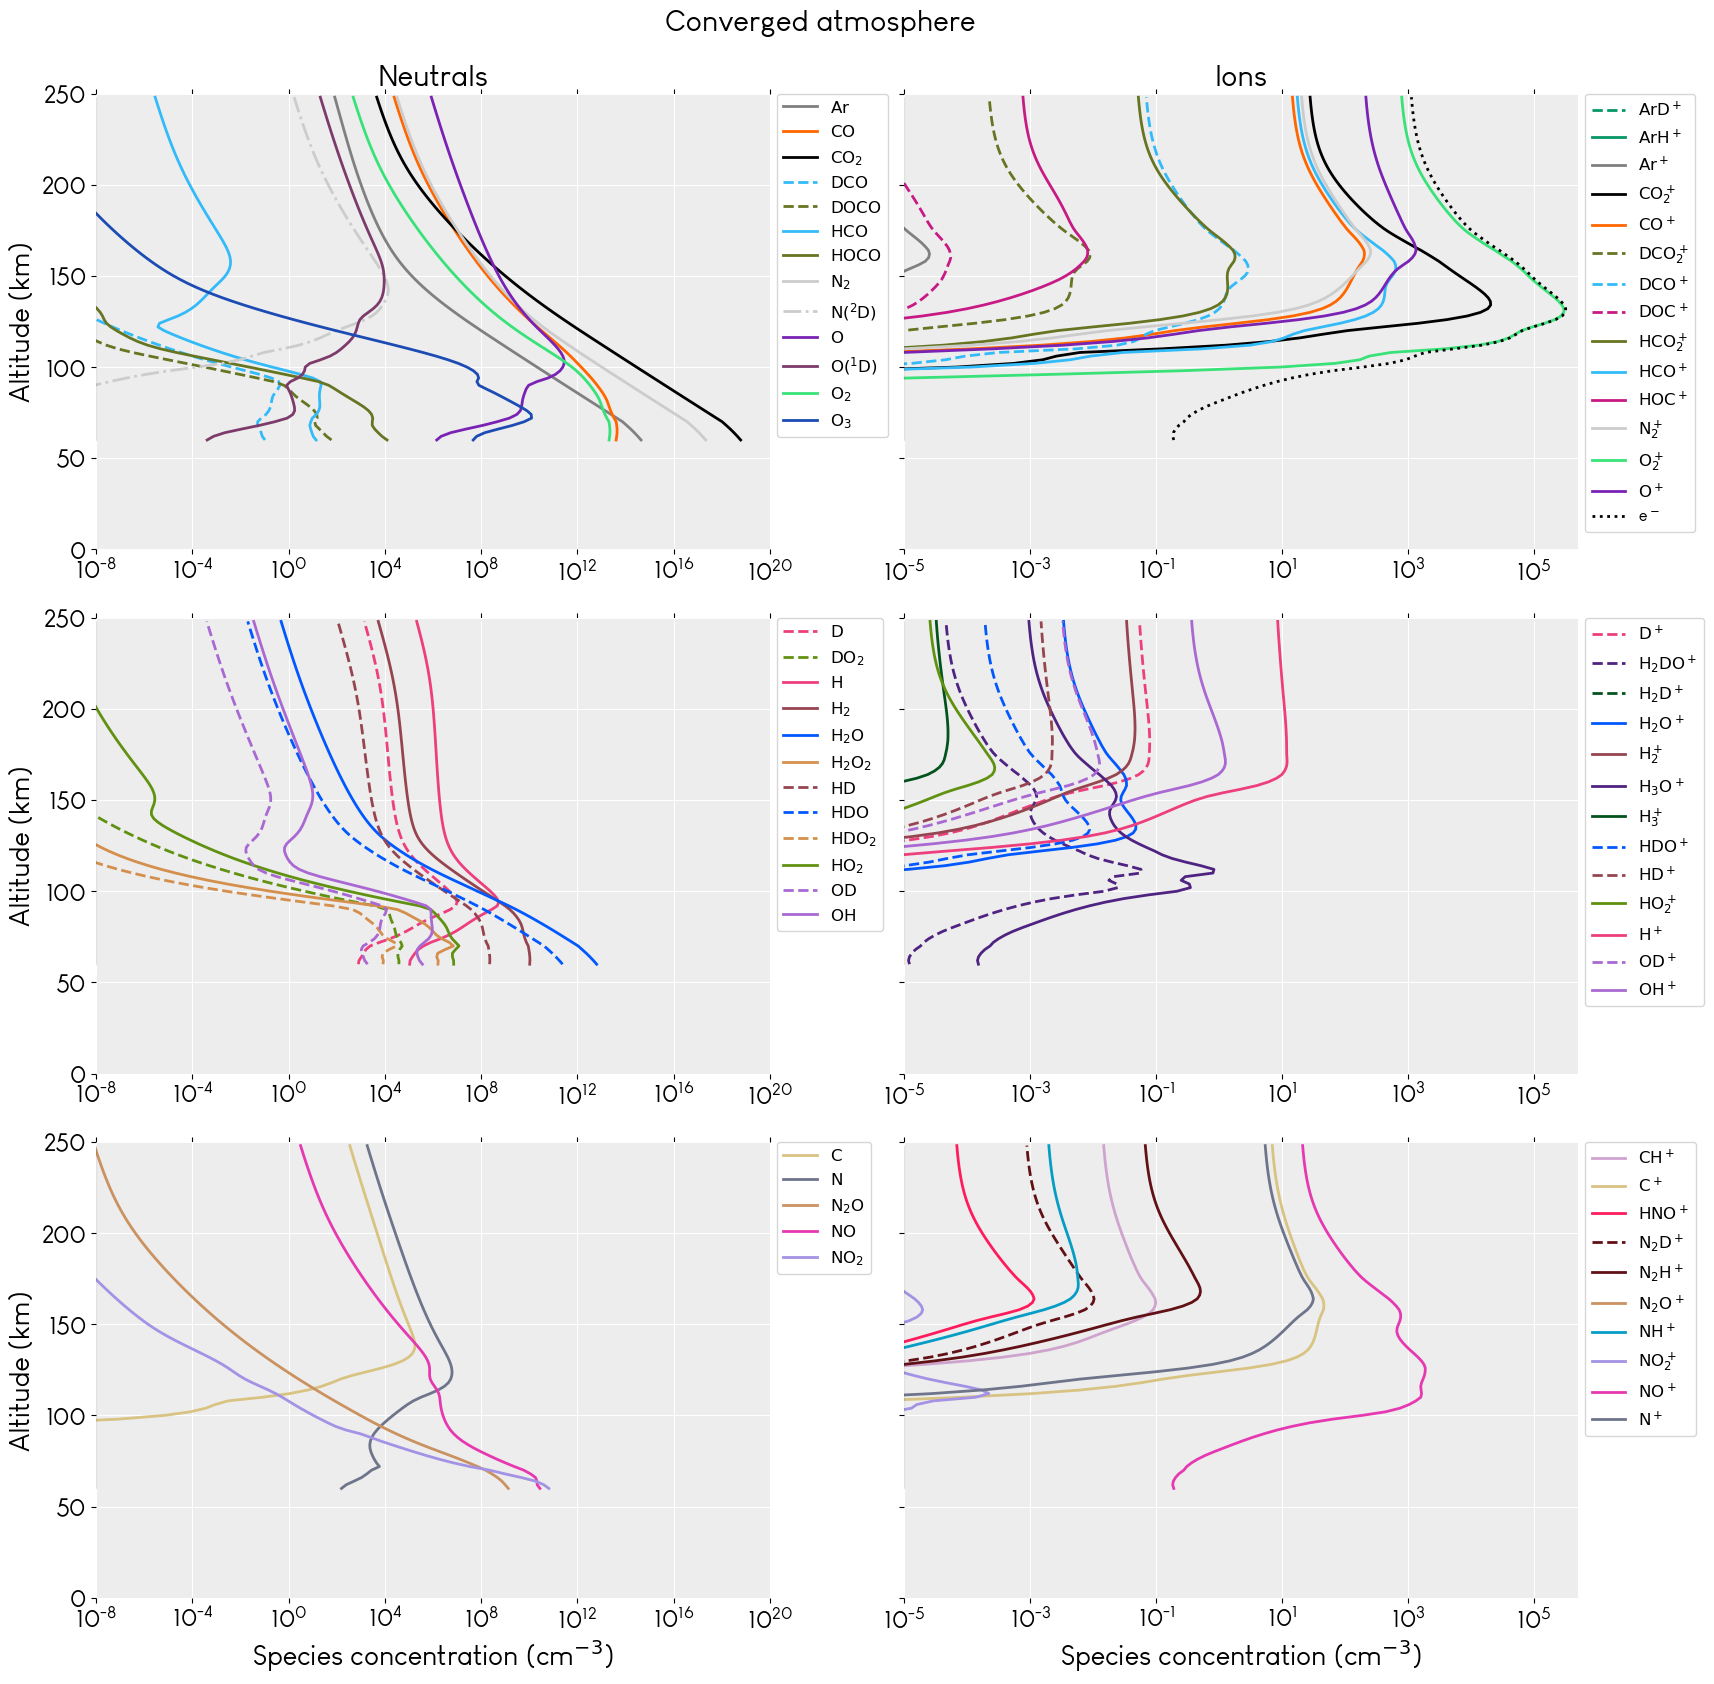

In [9]:
plot_atm(mean_atm, all_result_plot_folder*"final_atm_for_SI.png", 1e-12, electron_density(mean_atm; e_profile_type="quasineutral", ion_species, non_bdy_layers); 
         print_shortcodes=false, t="Converged atmosphere", xlim_2=(1e-5, 5e5), showonly=true, neutral_species, ion_species, plot_grid, speciescolor, speciesstyle, zmax)

## H and D ion detail

In [7]:
ions_to_plot = [:HDpl, :H2Dpl, :H2DOpl, :HDOpl, :Dpl, :DCO2pl, :DCOpl, :ArDpl, :N2Dpl, :ODpl,
                :H2pl, :H3pl,  :H3Opl,  :H2Opl, :Hpl, :HCO2pl, :HCOpl,  :ArHpl, :N2Hpl, :OHpl]#, :NOpl, :HOCpl,
panel_groups = Dict(1=>[:H2Dpl, :H3pl,  :HDOpl, :H2Opl, :Dpl, :Hpl, :H2DOpl, :H3Opl, :ODpl, :OHpl,  ], 
                    2=>[:ArDpl, :ArHpl, :N2Dpl, :N2Hpl,  :DCOpl, :HCOpl,  :DCO2pl, :HCO2pl, :HOCpl, :H2pl, :HDpl, :NOpl]) # :DOCpl,
axes_by_sp = Dict()
for k in keys(panel_groups)
    for sp in panel_groups[k]
        axes_by_sp[sp] = k
    end
end

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


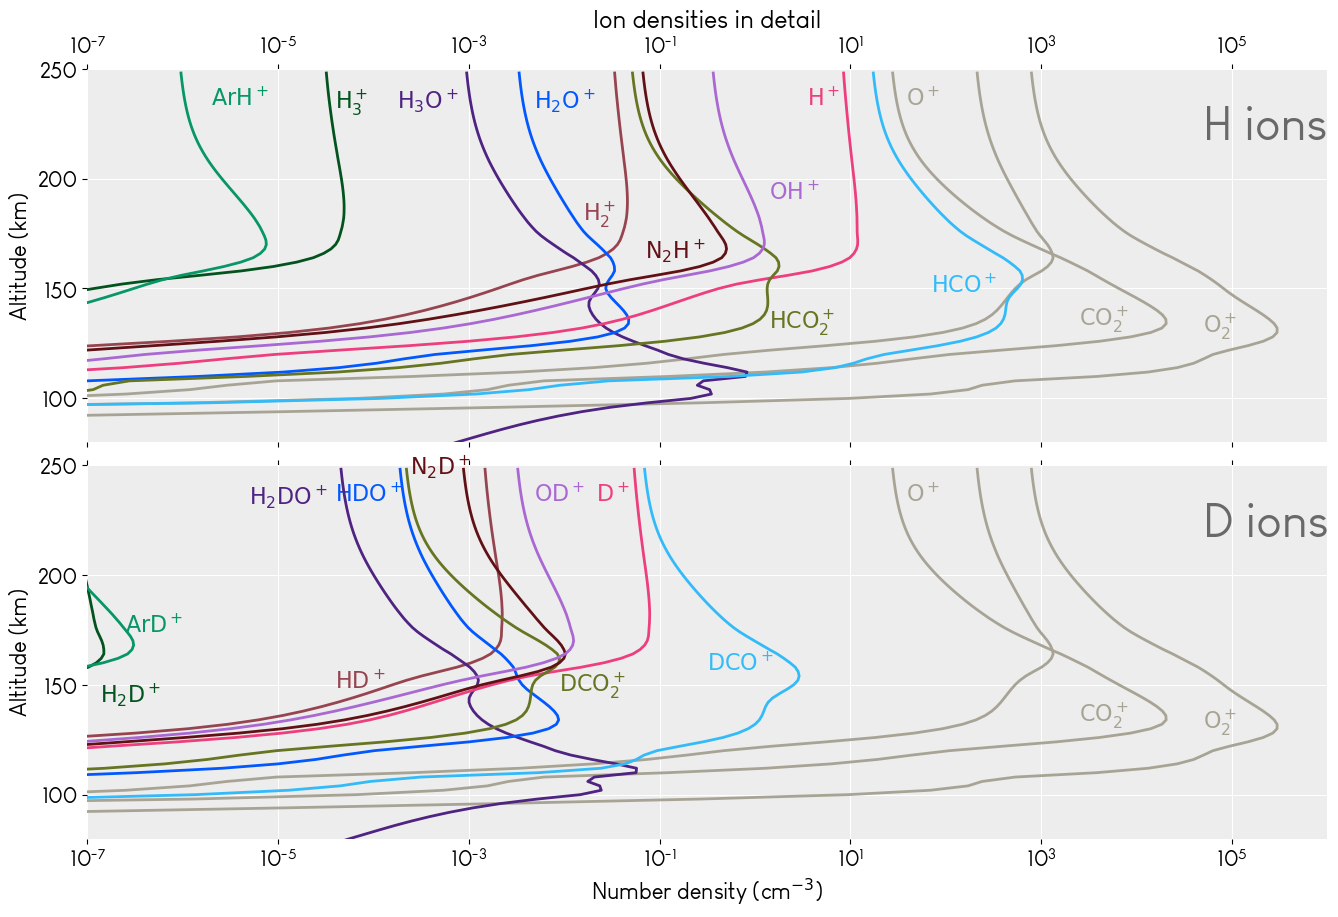

In [8]:
plot_ion_ranges_wide_2panel(ions_to_plot, mean_folder, all_result_plot_folder; extra_fn="_densities", 
                 xL = [1e-7; 1e6],    
                 posdict = Dict(:ArHpl => [0.1, 0.95], :Hpl => [0.58, 0.95], :HCOpl=>[0.68, 0.45], :HCO2pl => [0.55, 0.36],
                                 :H2Opl => [0.36, 0.95], :H3Opl => [0.25, 0.95], :H2pl => [0.4, 0.65], 
                                 :H3pl => [0.2, 0.95], :N2Hpl => [0.45, 0.55], :OHpl => [0.55, 0.7],
                                 :CO2pl=>[0.8, 0.37], :O2pl=>[0.9, 0.35], :Opl=>[0.66, 0.95],  
    
                                 :ArDpl => [0.03, 0.6], :Dpl => [0.41, 0.95], :DCOpl => [0.5, 0.5], :DCO2pl => [0.38, 0.45],
                                 :HDOpl => [0.2, 0.95], :H2DOpl => [0.13, 0.95], :HDpl => [0.2, 0.45], 
                                 :H2Dpl => [0.01, 0.42], :N2Dpl => [0.26, 1.03], :ODpl => [0.36, 0.95], 
                                 ))

# Escape

In [20]:
# LOad the reaction network for hot stuff cause we need that
reaction_network, hHnet, hDnet, hH2net, hHDnet = load_reaction_network("REACTION_NETWORK_VENUS.xlsx"; get_hot_rxns=true, all_species);
hHrc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hHnet]);
hDrc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hDnet]);
hH2rc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hH2net]);
hHDrc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hHDnet]);

In [21]:
esc_df = final_escape(mean_folder, "final_atmosphere.h5"; alt, all_species, dz, hHnet, hDnet, hH2net, hHDnet, hHrc, hDrc, hH2rc, hHDrc)

,EscapeType,H,D,H2,HD,Hpl,H2pl
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,Thermal,11.8176,4.17674e-12,1.5883e-11,1.54804e-23,6523.02,0.0306167
2,Nonthermal,1.52286e7,34347.8,1404.55,18.4676,0.0,0.0
3,Total,1.52286e7,34347.8,1404.55,18.4676,6523.02,0.0306167


In [22]:
show(esc_df, allcols=true)


3×10 DataFrame
 Row │ EscapeType  H           D                H2             HD            Hpl      H2pl       TotalNeutralHAtomsLost  TotalNeutralDAtomsLost  TotalNeutralAtomsLost 
     │ String      Float64     Float64          Float64        Float64       Float64  Float64    Float64                 Float64                 Float64               
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Thermal     11.8176         4.17674e-12     1.5883e-11   1.54804e-23  6523.02  0.0306167            6534.87                13057.9                26127.7
   2 │ Nonthermal   1.52286e7  34347.8          1404.55        18.4676          0.0   0.0                     1.52314e7               1.52658e7              4.5763e7
   3 │ Total        1.52286e7  34347.8          1404.55        18.4676       6523.02  0.0306167               1.5238e7                1.52788e7           

## Fractionation

In [23]:
hdo_bottom = mean_atm[:HDO][1]
h2o_bottom = mean_atm[:H2O][1]

6.367894534060739e12

In [24]:
fractionation_factor(esc_df, h2o_bottom, hdo_bottom)

0.11751434130250023

In [25]:
fractionation_factor(esc_df, h2o_bottom, hdo_bottom; ftype="thermal")

1.840801163813948e-11

In [26]:
fractionation_factor(esc_df, h2o_bottom, hdo_bottom; ftype="nonthermal")

0.11751443247838952

## Top mechanisms of escape

In [32]:
function plot_top5_lineandbar(total_dfs_H, total_dfs_D, by_alt_dfs_H, by_alt_dfs_D; savepath=nothing, nrow=1, ncol=2,
                              lowerlim=1e-5, upperlim=1, coltitle=["Mean atm"], 
                              h=0.1, w=0.1, title_y=[1.2, 1.05, 1.05]) 
    #=
    Input:
        sp: H or D usually
        total_dfs: Array of dataframes of total fluxes by reaction
        by_alt_dfs: Array of dataframes containing production profiles by altitude and by reaction
    Output: 
        Plot of the production profiles of the 5 reactions that produce the most flux
        of hot H and D.
    =#
    
    # Generate colors
    colordf = DataFrame(XLSX.readtable("IMPORTANT_RXN_COLORS.xlsx", "Sheet1"));

    # make labels not suck
    format_scin(n) = @sprintf "%.2E" n
    
    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 18
    rcParams["axes.labelsize"]= 20
    rcParams["xtick.labelsize"] = 18
    rcParams["ytick.labelsize"] = 18
    
    
    # Set up the figure dimensions
    npanel = nrow > ncol ? nrow : ncol 
    println("npanel: $npanel")
    fig, ax = subplots(nrow, ncol, figsize=(7.5*ncol, 5*nrow))
    subplots_adjust(wspace=w, hspace=h)
    
    println(size(ax))
    
    # SET UP THE REACTION RATE SET -----------------------------------------------------
  
    # all panels
    plot_bg(ax[1])
    ax[1].set_ylabel("Altitude (km)")
    # ax[1].text(1.07, title_y[i], coltitle, transform=ax[i, 1].transAxes, size=20)
    ax[1].set_xlim(lowerlim[1], upperlim[1]) # H plot limits
    ax[1].tick_params(which="both", labeltop=false, labelbottom=true, top=true)
    ax[1].set_ylim(100, 250)
    ax[1].set_xscale("log")
    ax[1].set_title("Production mechanisms", size=16)
    ax[1].set_xlabel(L"Volume production rate (cm$^{-3}$ s$^{-1}$)")
    
    # color set
    # H is first column, D second column
    H_colororder = []
    H_colororder_dark = []
    D_colororder = []
    D_colororder_dark = []
    # Plot the H reactions
    for row in eachrow(total_dfs_H)[1:5]
        thiscol = colordf[in([row.Rxn]).(colordf."H reaction"), :]."Color"[1]
        push!(H_colororder, thiscol)
        push!(H_colororder_dark, colordf[in([row.Rxn]).(colordf."H reaction"), :]."Darker"[1])
        ax[1].plot(by_alt_dfs_H[!, row.Rxn], plot_grid, label=row.Rxn, linewidth=2, color=thiscol)
    end
    # And the D reactions
    for row in eachrow(total_dfs_D)[1:5]
        thiscol = colordf[in([row.Rxn]).(colordf."D reaction"), :]."Color"[1]
        thiscol_dark = colordf[in([row.Rxn]).(colordf."D reaction"), :]."Darker"[1]
        push!(D_colororder, thiscol)
        push!(D_colororder_dark, thiscol_dark)

        ax[1].plot(by_alt_dfs_D[!, row.Rxn], plot_grid, label=row.Rxn, linewidth=2, linestyle=(0, (10,4)),
                 mfc="black", mec="black", color=thiscol)
    end
    
    println(H_colororder)
    
    
    rcParams["hatch.linewidth"] = 1
    rcParams["hatch.color"] = "magenta"
    # NOW DO THE BAR CHART SET -------------------------------------------------------------------------
    # Make ticklabels
    H_ticklbls = ["$(string_to_latexstr(H_i))" for H_i in total_dfs_H[1:5, :].Rxn]
    D_ticklbls = ["$(string_to_latexstr(D_i))" for D_i in total_dfs_D[1:5, :].Rxn]

    # basics
    plot_bg(ax[2])
    ax[2].tick_params(top=true, left=false, labelleft=false)
    ax[2].set_xlim(1e2, 1e8)
    ax[2].set_xscale("log")
    ax[2].invert_yaxis()

    # Bars 
    barw=0.5
    ax[2].barh(collect(1:5), total_dfs_H[1:5, :].Value, height=-barw, color=H_colororder, align="edge", zorder=10, edgecolor=H_colororder_dark)
    ax[2].barh(collect(1:5), total_dfs_D[1:5, :].Value, height=barw, color=D_colororder,  fill=false, 
                  align="edge", zorder=10, hatch="///", edgecolor=D_colororder)

    # Values
    for (i, f) in enumerate(total_dfs_H[1:5, :].Value)
        ax[2].text(f*0.9, i-barw/2, "$(format_scin(f))", ha="right", va="center", color="white", size=12, zorder=15)
    end
    for (i, f) in enumerate(total_dfs_D[1:5, :].Value)
        ax[2].text(f*1.2, i+barw/2, "$(format_scin(f))", ha="left", va="center", color="black", size=12, zorder=15)
    end

    # Tick labels, but manually, to make coloring better
    x = 7e1
    for y in 1:5
        ax[2].text(x, y - 0.15, H_ticklbls[y], color=H_colororder[y], fontsize=14, ha="right")
        ax[2].text(x, y + 0.35, D_ticklbls[y], color=D_colororder[y], fontsize=14, ha="right")
    end
    
    ax[2].set_title("Reaction contributions to escape", size=16)
    ax[2].set_xlabel(L"H & D Escape flux (cm$^{-2}$s$^{-1}$)")
    
    # Label H and D
    ax[1].text(1e-7, 160, "D-bearing")
    ax[1].text(1e-2, 120, "H-bearing")
    
    if savepath!=nothing
        savefig(savepath*"hot_mechanisms_line_bar.png", bbox_inches="tight", dpi=300)
    else
        show()
    end
end

plot_top5_lineandbar (generic function with 1 method)

In [28]:
# Get the Jratelist because we need it for nonthermal bcs
Jratelist = format_Jrates(mean_folder*"active_rxns.xlsx", all_species, "Jratelist"; hot_atoms=true, ions_on=true)[1];
Jratedict = Dict([j=>mean_atm[j] for j in Jratelist])

Mtot = sum([mean_atm[sp] for sp in all_species]);
# H
H_prod_by_alt = escaping_hot_atom_production(:H, hHnet, hHrc, mean_atm, Mtot; all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax);
H_prod_by_alt_df = escaping_hot_atom_production(:H, hHnet, hHrc, mean_atm, Mtot; returntype="df", all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax);
total_hot_H = nonthermal_escape_flux(hHnet, H_prod_by_alt; dz); # This is already sorted within the function here.

D_prod_by_alt = escaping_hot_atom_production(:D, hDnet, hDrc, mean_atm, Mtot; all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)
D_prod_by_alt_df = escaping_hot_atom_production(:D, hDnet, hDrc, mean_atm, Mtot; returntype="df", all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)
total_hot_D = nonthermal_escape_flux(hDnet, D_prod_by_alt; dz);

npanel: 2
(2,)
Any["#e23209", "#44AA99", "#CC6677", "#332288", "#882255"]


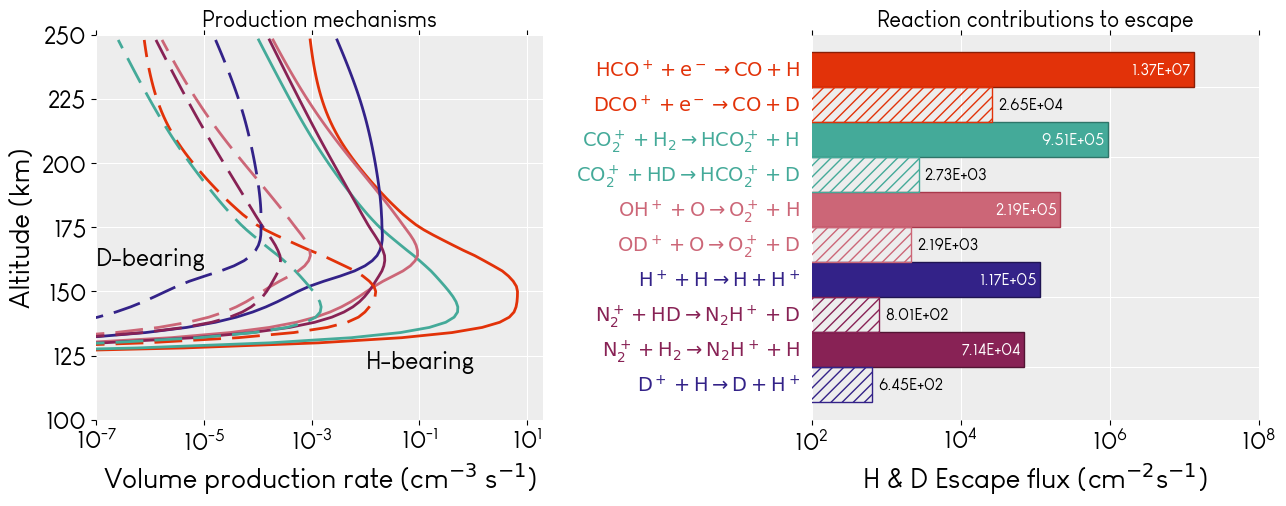

In [33]:
plot_top5_lineandbar(total_hot_H, total_hot_D, H_prod_by_alt_df, D_prod_by_alt_df; savepath=all_result_plot_folder,
                     nrow=1, ncol=2,
                     lowerlim=[1e-7,1e-7,1e-7], upperlim=[20,20,20], w=0.6, h=0.25,
                     coltitle=["Mean atmo"])